In [65]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [66]:
print(torch.cuda.is_available())

True


## Prepare data

In [67]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [68]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)

In [69]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [70]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)
    
    def forward(self, hidden_states):
        attention_weights = torch.softmax(self.attention(hidden_states), dim=1)
        context_vector = torch.sum(attention_weights * hidden_states, dim=1)
        return context_vector

class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(LSTMAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)
        
        self.attention = AttentionLayer(hidden_size)
        
        
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        # attn_out = self.attention(lstm_out)
        
        
        fc1_out = F.relu(self.fc1(lstm_out[:, -1, :]))
        fc1_out = self.dropout(fc1_out)
        
        fc2_out = F.relu(self.fc2(fc1_out))
        fc2_out = self.dropout(fc2_out)
        
        
        
        output = self.fc3(fc2_out)
        
        return output



In [72]:
def prepare_data(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        
        X_seq.append(X[i:i+seq_length])
        
        y_seq.append(y[i+seq_length])
        
    return np.array(X_seq), np.array(y_seq)
seq_length = 10

X_train_seq, y_train_seq = prepare_data(X_train, y_train, seq_length)
X_val_seq, y_val_seq = prepare_data(X_val, y_val, seq_length)
X_test_seq, y_test_seq = prepare_data(X_test, y_test, seq_length)

#GPU

X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)



In [76]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Assuming MultitaskLSTMModel and AttentionLayer are defined as in your provided code

# Hyperparameters

input_size = X_train_tensor.shape[2]  # number of features
hidden_size = 128
num_layers = 4
num_epochs = 100
batch_size = 32
learning_rate = 0.001

# Create DataLoaders without shuffling
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device("cuda")
model = LSTMAttention(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
step_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Training process
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    # step_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test the model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy().squeeze()

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = np.mean((predictions - y_test) ** 2)
print(f"Test MSE: {mse:.4f}")

Epoch 1/100, Train Loss: 159660.7748, Val Loss: 7432.1803
Epoch 2/100, Train Loss: 159519.8868, Val Loss: 7446.3721
Epoch 3/100, Train Loss: 159388.3447, Val Loss: 7447.9177
Epoch 4/100, Train Loss: 159493.7637, Val Loss: 7443.0000
Epoch 5/100, Train Loss: 159450.8870, Val Loss: 7454.5282
Epoch 6/100, Train Loss: 159469.9382, Val Loss: 7440.7029
Epoch 7/100, Train Loss: 159486.4725, Val Loss: 7440.8398
Epoch 8/100, Train Loss: 159373.4613, Val Loss: 7427.4841
Epoch 9/100, Train Loss: 159440.6626, Val Loss: 7442.3169
Epoch 10/100, Train Loss: 159457.9260, Val Loss: 7430.9565
Epoch 11/100, Train Loss: 159462.9680, Val Loss: 7434.1118
Epoch 12/100, Train Loss: 159450.9797, Val Loss: 7441.6972
Epoch 13/100, Train Loss: 159431.4935, Val Loss: 7440.6064


KeyboardInterrupt: 

Mean Squared Error: 69911.6562
Mean Absolute Error: 86.3324
Root Mean Squared Error: 264.4081


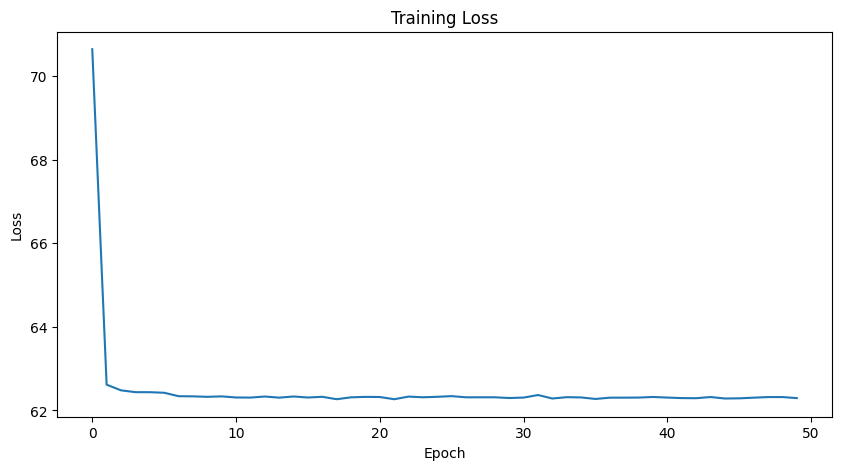

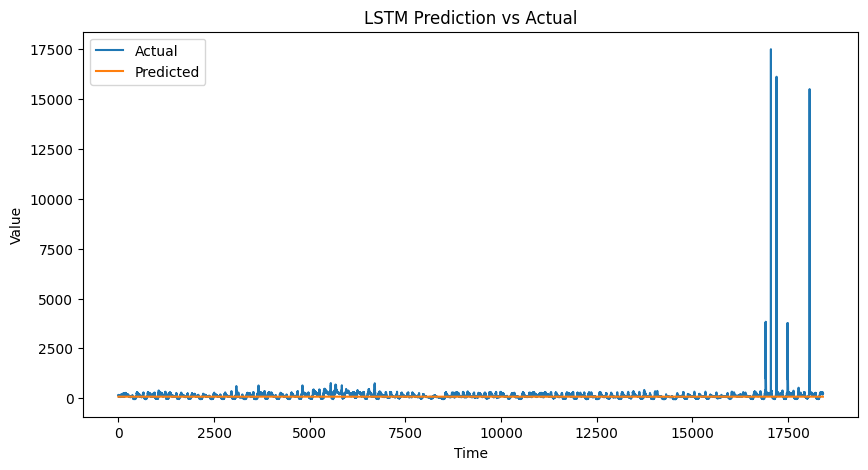

In [22]:
#Evaluate model
from sklearn.metrics import mean_squared_error,mean_absolute_error
model.to("cpu")
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_true = y_test_tensor.cpu().numpy()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Prediction vs Actual')
# plt.ylim([-100, 10000])
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
for i in y_pred:
    
    print(i)

[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.074715]
[77.